In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical  
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Dense, Activation, GlobalAveragePooling2D, ZeroPadding2D, add, Concatenate

## Load the data

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 3)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 3)

## one hot encode the labels

In [4]:
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

## Normalize the Input

In [5]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [6]:
train_images = normalize(train_images)
test_images = normalize(test_images)

In [7]:
train_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(train_images, tf.float32),
            tf.cast(train_labels, tf.uint8))))

test_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(test_images, tf.float32),
            tf.cast(test_labels, tf.uint8))))

2021-12-05 19:35:02.685539: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocess the data

In [8]:
def preprocessing(ds):
    ds = ds.map(lambda feature, label: (feature,label))
    ds = ds.cache()
    ds = ds.shuffle(32)
    ds = ds.batch(64)
    ds = ds.prefetch(20)
    return ds

In [9]:
train_ds = train_tfds.apply(preprocessing)
test_ds = test_tfds.apply(preprocessing)

## The Residual Block Class

In [12]:
class ResidualBlock(tf.keras.Model):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv_layer1 = Conv2D(filters=6,
                                       kernel_size=(1,1),  
                                       padding="same")
        self.batchnorm1 = BatchNormalization()

        self.conv_layer2 = Conv2D(filters=5,
                                       kernel_size=(3,3),  
                                       padding="same")
        self.batchnorm2 = BatchNormalization()

        self.conv_layer3 = Conv2D(filters=3, 
                                       kernel_size=(1,1),  
                                       padding="same")
        self.batchnorm3 = BatchNormalization()


    def call(self, inputs):
        conv_layer1_output = self.conv_layer1(inputs)
        batchnorm1_output = self.batchnorm1(conv_layer1_output, training = True)

        conv_layer2_output = self.conv_layer2(batchnorm1_output)
        batchnorm2_output = self.batchnorm2(conv_layer2_output, training = True)
        
        conv_layer3_output = self.conv_layer3(batchnorm2_output)
        batchnorm3_output = self.batchnorm3(conv_layer3_output, training = True)
        

        return add([inputs, batchnorm3_output])

## The Residual Net Class

In [11]:
class ResNet(tf.keras.Model):
    def __init__(self, number_of_res_block, loss_function, optimizer= None):
        super(ResNet, self).__init__()

        self.res_blocks = [ResidualBlock() for _ in range(number_of_res_block)]


        self.global_avg_pooling = GlobalAveragePooling2D()

        self.output_layer = Dense(10, activation='softmax')

        self.loss_function = loss_function
        self.optimizer = optimizer

    
    def call(self, inputs):
        output_res_blocks = inputs

        for res_block in self.res_blocks:
            output_res_blocks = res_block(output_res_blocks)

        output_global_avg_pooling = self.global_avg_pooling(output_res_blocks)
        output = self.output_layer(output_global_avg_pooling)

        return output
    
     
    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        same_prediction = np.round(target,0) == np.round(prediction, 0)
        accuracy = np.mean(same_prediction)
        return loss, accuracy

    def test(self, test_data):
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input, target in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            same_prediction = np.round(target,0) == np.round(prediction, 0)
            accuracy = np.mean(same_prediction)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy

In [51]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 6
LEARNING_RATE = 0.001

# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Initialize the model
model_resnet = ResNet(number_of_res_block= 2, loss_function = cross_entropy_loss, optimizer = optimizer)

# Initialize lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Testing models performance before training starts.
# Test-Dataset
test_loss, test_accuracy = model_resnet.test(test_ds)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
# Train-Dataset
train_loss, train_accuracy = model_resnet.test(train_ds)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# Training for EPOCHS.
for epoch in range(EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input, target in train_ds:
        train_loss, train_accuracy = model_resnet.train(input, target)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    # track training loss and accuracy
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
    # track loss and accuracy for test-dataset
    test_loss, test_accuracy = model_resnet.test(test_ds)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 0 starting with test-accuracy of 0.9
Epoch 1 starting with test-accuracy of 0.9
Epoch 2 starting with test-accuracy of 0.9
Epoch 3 starting with test-accuracy of 0.9
Epoch 4 starting with test-accuracy of 0.9
Epoch 5 starting with test-accuracy of 0.9
Epoch 6 starting with test-accuracy of 0.9


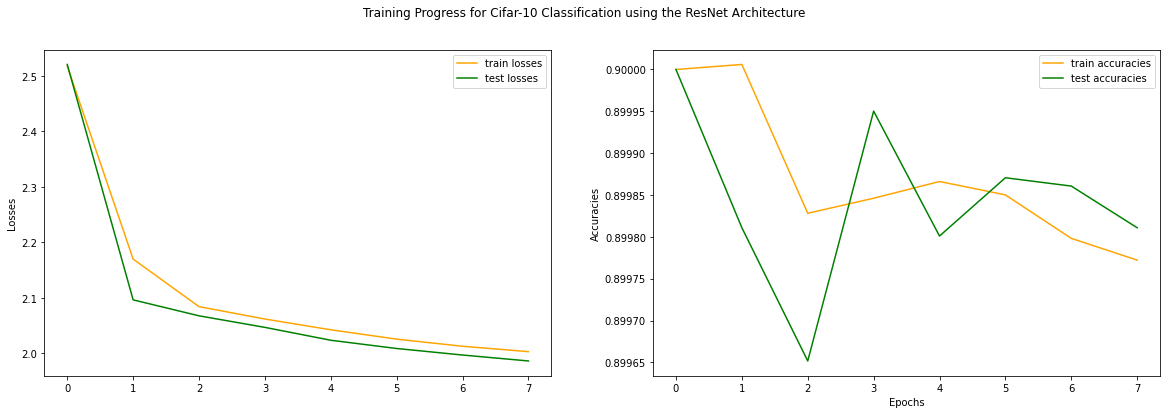

In [52]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

fig.suptitle('Training Progress for Cifar-10 Classification using the ResNet Architecture')
axs[0].plot(train_losses, color='orange', label='train losses')
axs[0].plot(test_losses, color='green', label='test losses')
axs[0].set(ylabel='Losses')
axs[0].legend()
axs[1].plot(train_accuracies, color='orange', label='train accuracies')
axs[1].plot(test_accuracies, color='green', label='test accuracies')

axs[1].set(xlabel='Epochs', ylabel='Accuracies')
axs[1].legend()

## The Transition Layer Class

In [45]:
class TransitionLayers(tf.keras.Model):
    def __init__(self, x):
        super(TransitionLayers, self).__init__()

        reduce_filters_to = x // 2 
        self.conv_layer = Conv2D(filters=reduce_filters_to, 
                                       kernel_size=(1,1),  
                                       padding="valid", use_bias=False)

        self.batchnorm = BatchNormalization()

        self.activation = Activation(tf.nn.relu)

        self.pool = AveragePooling2D(pool_size=(2,2), strides = (2,2), padding = 'valid')

    def call(self, input):
        output_conv_layer = self.conv_layer(input)
        output_batchnorm = self.batchnorm(output_conv_layer, training = True)

        output_relu = self.activation(output_batchnorm)

        output = self.pool(output_relu)

        return output
        

## Block Class

In [46]:
class Block(tf.keras.layers.Layer):
    def __init__(self, num_filters, padding):
        super(Block, self).__init__()
        
        self.batchnorm = BatchNormalization()
        self.activation = Activation(tf.nn.relu)

        self.conv_layer = Conv2D(filters=num_filters, 
                                       kernel_size=(1,1),  
                                       padding=padding, use_bias=False)

    def call(self, input):
        batchnorm_output = self.batchnorm(input, training = True)
        activation_output = self.activation(batchnorm_output)

        output = self.conv_layer(activation_output)

        return Concatenate(axis=3)([input, output])

## Dense Block Class

In [21]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, new_channels, num_blocks):
        super(DenseBlock, self).__init__()
        # the first convolution does zero-padding to avoid losing information in the edges of the input
        self.block1 = Block(num_filters, padding='valid')
        self.blocks = []
        if num_blocks > 2 and num_blocks == len(new_channels):
            self.blocks = [Block(new_channel, padding='same') for new_channel in new_channels]

        else:
            self.block2 = Block(new_channels, padding='same')

    def call(self, input):
        output_block1 = self.block1(input)
        output_blocks = output_block1

        if len(self.blocks) > 1:
            for block in self.blocks:
                output_blocks = block(output_blocks)
            return output_blocks
            
        return self.block2(output_block1)


## Dense Net Class

In [47]:
class DenseNet(tf.keras.Model):
    def __init__(self, loss_function, optimizer= None):
        super(DenseNet, self).__init__()

        self.optimizer = optimizer
        self.loss_function = loss_function
        # apply symmetric padding
        self.zero_padding1 = ZeroPadding2D(padding=(3, 3), data_format=None)

        self.conv1  = Conv2D(filters = 64, kernel_size=(3,3), padding="valid", use_bias=False)

        self.batch_norm1 = BatchNormalization(epsilon=1.001e-05)
        self.activation1 = Activation(tf.nn.relu)

        # apply symmetric padding again as implemented in the courseware
        self.zero_padding2 = ZeroPadding2D(padding=(1, 1), data_format=None)

        self.pool1 = AveragePooling2D(pool_size=(3,3), strides=(2,2), padding="valid")

        self.dense_blocks = []
        # 2 DenseBlocks forming the first Block
        self.dense_blocks.append(DenseBlock(num_filters=128, new_channels=32, num_blocks=2))

        # Transition layer to reduce resolution and reduce the number of feature maps to half
        self.dense_blocks.append(TransitionLayers(128))

        # 2 DenseBlocks forming the second Block
        self.dense_blocks.append(DenseBlock(num_filters=128, new_channels=32, num_blocks=2))

        # Transition layer to reduce resolution and reduce the number of feature maps to half
        self.dense_blocks.append(TransitionLayers(128))

        # 2 DenseBlocks forming the third Block
        self.dense_blocks.append(DenseBlock(num_filters=128, new_channels=32, num_blocks=2))

        self.batch_norm2 = BatchNormalization(epsilon=1.001e-05)
        self.activation2 = Activation(tf.nn.relu)

        # We use global average pooling to transform the feature maps into feature vectors that work with Dense Layers.
        self.pool2 = GlobalAveragePooling2D()

        self.ouput = Dense(10, activation="softmax")


    def call(self, input):
        ouput_zero_padding1 = self.zero_padding1(input)
        output_conv1 = self.conv1(ouput_zero_padding1)

        output_batch_norm1 = self.batch_norm1(output_conv1, training = True)
        output_activation1 = self.activation1(output_batch_norm1)

        output_zero_padding2 = self.zero_padding2(output_activation1)

        output_pool1 = self.pool1(output_zero_padding2)

        output_blocks = output_pool1
        for block in self.dense_blocks:
            output_blocks = block(output_blocks)

        output_batch_norm2 = self.batch_norm2(output_blocks, training = True)
        output_activation2 = self.activation2(output_batch_norm2)


        output_pool2 = self.pool2(output_activation2)

        return self.ouput(output_pool2)

    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        same_prediction = np.round(target,0) == np.round(prediction, 0)
        accuracy = np.mean(same_prediction)
        return loss, accuracy

    def test(self, test_data):
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input, target in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            same_prediction = np.round(target,0) == np.round(prediction, 0)
            accuracy = np.mean(same_prediction)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy

In [48]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 6
LEARNING_RATE = 0.001

# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Initialize the model
model = DenseNet(loss_function = cross_entropy_loss, optimizer = optimizer)

# Initialize lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Testing models performance before training starts.
# Test-Dataset
test_loss, test_accuracy = model.test(test_ds)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
# Train-Dataset
train_loss, train_accuracy = model.test(train_ds)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# Training for EPOCHS.
for epoch in range(EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input, target in train_ds:
        train_loss, train_accuracy = model.train(input, target)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    # track training loss and accuracy
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
    # track loss and accuracy for test-dataset
    test_loss, test_accuracy = model.test(test_ds)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 0 starting with test-accuracy of 0.899
Epoch 1 starting with test-accuracy of 0.918
Epoch 2 starting with test-accuracy of 0.924
Epoch 3 starting with test-accuracy of 0.928
Epoch 4 starting with test-accuracy of 0.93
Epoch 5 starting with test-accuracy of 0.932
Epoch 6 starting with test-accuracy of 0.934


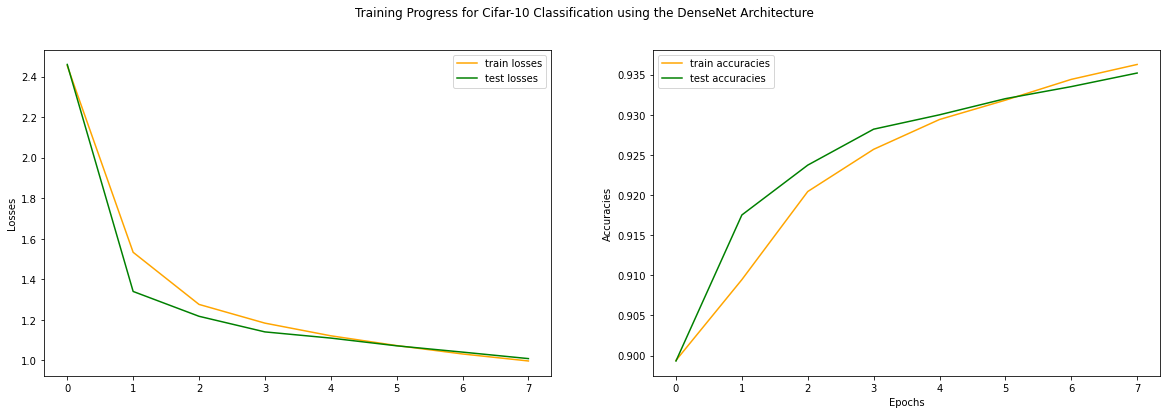

In [49]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

fig.suptitle('Training Progress for Cifar-10 Classification using the DenseNet Architecture')
axs[0].plot(train_losses, color='orange', label='train losses')
axs[0].plot(test_losses, color='green', label='test losses')
axs[0].set(ylabel='Losses')
axs[0].legend()
axs[1].plot(train_accuracies, color='orange', label='train accuracies')
axs[1].plot(test_accuracies, color='green', label='test accuracies')

axs[1].set(xlabel='Epochs', ylabel='Accuracies')
axs[1].legend()

In [50]:
model.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin multiple                  0         
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  15

In [53]:
model_resnet.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block (ResidualBloc multiple                  373       
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  373       
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  40        
Total params: 786
Trainable params: 730
Non-trainable params: 56
_________________________________________________________________
